# Stock Price Prediction With Recurrent Neural Networks

## Content:

1. [Data Cleaning](#1-data-cleaning)
2. [Correlation Analysis](#2-correlation-analysis)
3. [Feature Engineering](#3-feature-engineering)
4. [Machine Learning Models](#4-machine-learning-models)

    4.1 [Recurring Neural Networks (RNN)](#41-recurrent-neural-networks-rnn)
    
    4.2 [Long Short Term Memory (LSTM)](#42-long-short-term-memory-lstm)
    
    4.3 [Gated Recurring Units (GRUs)](#43-gated-recurring-units-grus)

5. [Results](#5-results)
6. [Conclusions](#6-conclusions)
7. [Next Steps](#7-next-steps)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import date, time

import yfinance as yf

import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout


The rise of AI has boosted the stock price of 7 big cap stocks, that in 2023 have provided a cumulative average return of 107% compared to the 26% of the SP 500.

In this analysis we want to perform EDA, to understand the movement of these stocks' prices, for example by looking at how they are correlated to each other. Their correlation will show for example, how these companies are exposed to the AI phenomenon, and if they have some alpha factor on their own.

Later on, we will pick one of these stocks and build a few models using Recurrent Neural Networks (RNN) that aim to predict the stock price.

Stock price prediction trhough RNN has been somewhat controversial, as it is very sensitive to outlayers and to the changes in the market and global landscape (e.g., Covid-19, AI buzz). However, it is possible, at least for short enough period of time, depending on the accuracy one's want to achieve. Past work has shown that it can be particularly good for monthly predictions, but that it can be less accurate for daily price forecast.

We shall start by downloading the stock price data from the Yahoo Finance API, and by concatenating the data into the same dataframe. The by adding a "Ticker" column, we will be able to group both by Ticker and Date.

In [8]:
tickers = ['GOOGL', 'MSFT', 'AAPL', 'AMZN', 'META', 'TSLA', 'NVDA']
dfs = []

for ticker in tickers:
    df = yf.download(ticker,
                     start='2004-08-19',
                     end=date.today(),
                     progress=False)
    df['Ticker'] = ticker  # Add a new column for ticker symbol
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs)

# Reset index to make it cleaner
combined_df.reset_index(inplace=True)

# Display the combined dataframe
print(combined_df)


            Date        Open        High         Low       Close   Adj Close  \
0     2004-08-19    2.502503    2.604104    2.401401    2.511011    2.511011   
1     2004-08-20    2.527778    2.729730    2.515015    2.710460    2.710460   
2     2004-08-23    2.771522    2.839840    2.728979    2.737738    2.737738   
3     2004-08-24    2.783784    2.792793    2.591842    2.624374    2.624374   
4     2004-08-25    2.626627    2.702703    2.599600    2.652653    2.652653   
...          ...         ...         ...         ...         ...         ...   
31120 2024-03-22  911.409973  947.780029  908.340027  942.890015  942.890015   
31121 2024-03-25  939.409973  967.659973  935.099976  950.020020  950.020020   
31122 2024-03-26  958.510010  963.750000  925.020020  925.609985  925.609985   
31123 2024-03-27  931.119995  932.400024  891.229980  902.500000  902.500000   
31124 2024-03-28  900.000000  913.000000  891.929993  903.559998  903.559998   

          Volume Ticker  
0      893181

In [9]:
#Save the dataframe into a pickle file so you can use it later without making further API requests.
combined_df.to_pickle('magnificent_seven_historic_prices.pkl')

Let's save the dataset also in a CSV format, in case we want to share it externally.

In [24]:
combined_df.to_csv('magnificent_seven_historic_prices.csv')

## 1. Data Cleaning

In [11]:
combined_df.shape

(31125, 8)

The dataframe has 8 columns and 31125 rows.

In [12]:
combined_df['Ticker'].value_counts()

Ticker
GOOGL    4936
MSFT     4936
AAPL     4936
AMZN     4936
NVDA     4936
TSLA     3461
META     2984
Name: count, dtype: int64

There is less data for TSLA and META, so we may want to consider reducing our data to 2984 rows.

In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31125 entries, 0 to 31124
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       31125 non-null  datetime64[ns]
 1   Open       31125 non-null  float64       
 2   High       31125 non-null  float64       
 3   Low        31125 non-null  float64       
 4   Close      31125 non-null  float64       
 5   Adj Close  31125 non-null  float64       
 6   Volume     31125 non-null  int64         
 7   Ticker     31125 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.9+ MB


It looks like every feature has the correct data format, so no conversion is needed for now. We will decide later if we want to convert "Date" from datetime64 to date with the dt. normalize() function.

In [15]:
combined_df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,31125,31125.000000,31125.000000,31125.000000,31125.000000,31125.000000,3.112500e+04
mean,2015-02-17 11:27:13.272289280,70.344932,71.289135,69.381791,70.368035,69.095853,1.298865e+08
min,2004-08-19 00:00:00,0.548393,0.553393,0.542143,0.548393,0.464269,1.777500e+06
25%,2010-10-04 00:00:00,10.125876,10.261512,9.964715,10.105355,9.856500,3.436400e+07
50%,2015-05-29 00:00:00,28.292000,28.570000,28.000000,28.270000,25.014719,6.295090e+07
75%,2019-10-28 00:00:00,103.660004,105.099998,102.010002,103.769997,101.995247,1.186556e+08
max,2024-03-28 00:00:00,958.510010,974.000000,935.099976,950.020020,950.020020,3.372970e+09
std,NaN,92.489114,93.852195,91.084974,92.522888,92.528632,2.152808e+08


For the moment, the describe() function does not seem very useful, as we have the prices of different tickers grouped together.

In [16]:
#Let's check for duplicates to make sure that for each ticker we do not have the same date repeated twice.
duplicate = combined_df[combined_df.duplicated(['Date', 'Ticker'], keep=False)]
duplicate.count()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Ticker       0
dtype: int64

Amazing! We have 0 duplicates.

Text(0.5, 1.0, 'Total Missing Values')

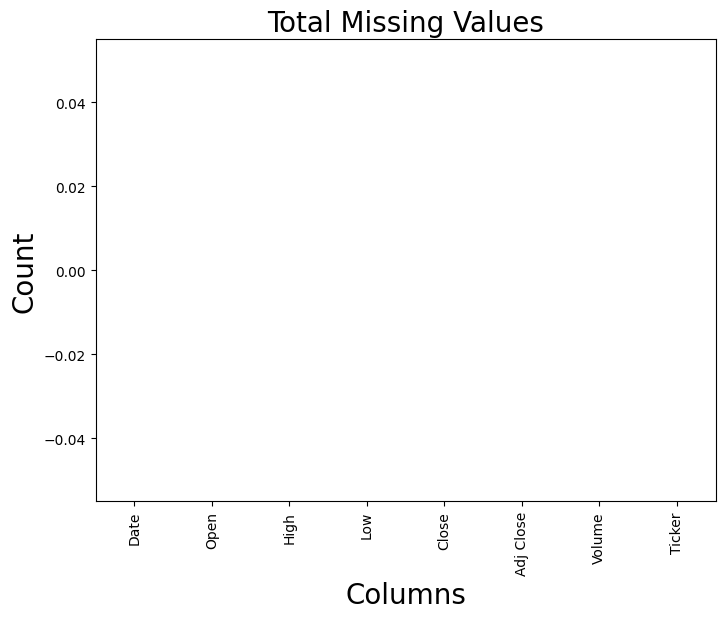

In [17]:
#Let's check for missing value
total_missing = combined_df.isnull().sum().sort_values(ascending=False)
total_missing_select = total_missing
total_missing_select.plot(kind="bar", figsize = (8,6), fontsize = 10)

plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Values", fontsize = 20)

We don't have any missing value. However, when we group by "Ticker", we will need to remember that Meta and Tesla have less dates worth of data.

## 2. Correlation Analysis

Before starting to build our models, we want to visualize our data and the correlations between the stock prices.

To plot the correlations, we need to group by "Ticker" and pick the price feature we want for our comparison. In this analysis, we are going to use the adjusted close price (Adj Close). The adjusted closing price is calculated starting from the closing price, and it takes into consideration also dividends, stock splits, and new stock offerings, then being more accurate.

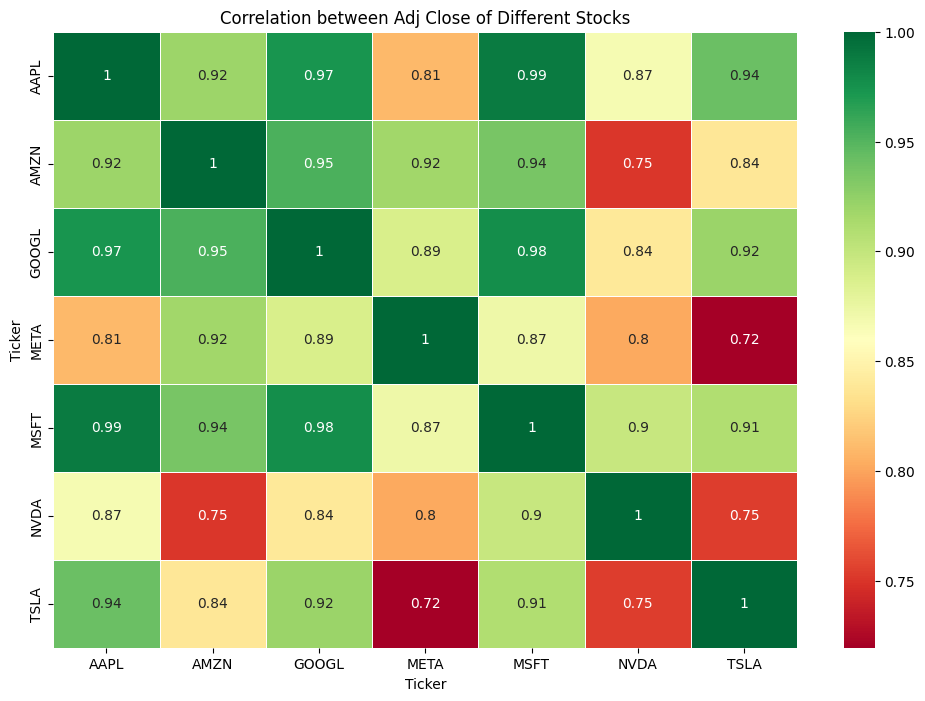

In [31]:
# Pivot the DataFrame to have "Ticker" as columns and "Adj Close" as values
pivot_df_1 = combined_df.pivot(index='Date', columns='Ticker', values='Adj Close')

# Calculate the correlation matrix
corr_matrix_1 = pivot_df_1.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_1, annot=True, cmap="RdYlGn", linewidths=0.5)
plt.title('Correlation between Adj Close of Different Stocks')
plt.xlabel('Ticker')
plt.ylabel('Ticker')
plt.show()

We see that all the values are strongly correlated.

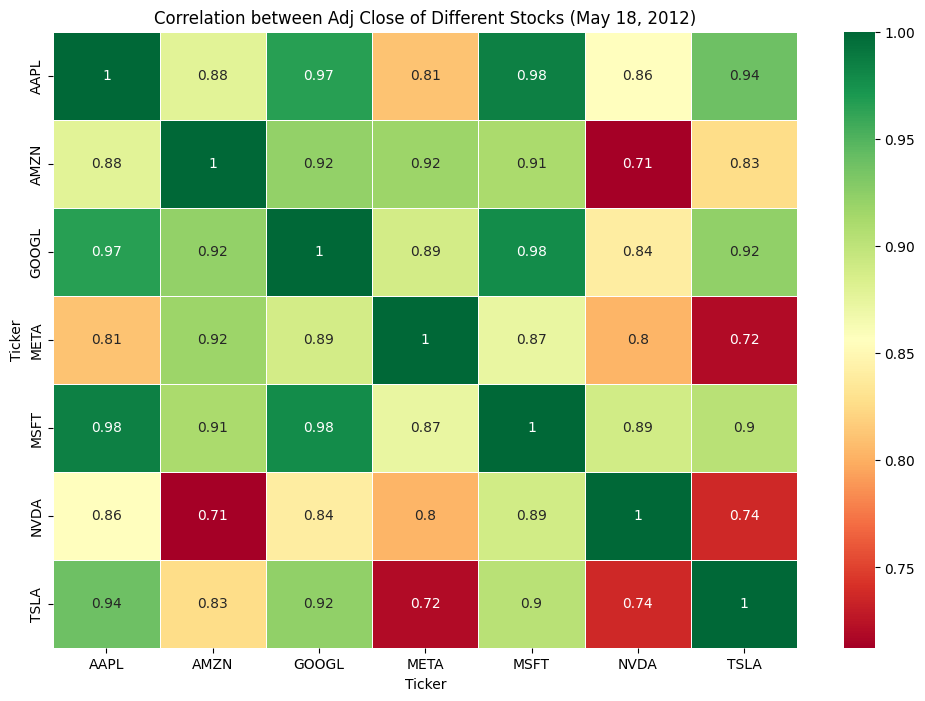

In [27]:
# Now let's filter the DataFrame to include data only from May 18, 2012, the day that Meta went public.
filtered_df_2 = combined_df[combined_df['Date'] >= '2012-05-18']

# Pivot the filtered DataFrame to have "Ticker" as columns and "Adj Close" as values
pivot_df_2 = filtered_df_2.pivot(index='Date', columns='Ticker', values='Adj Close')

# Calculate the correlation matrix
corr_matrix_2 = pivot_df_2.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_2, annot=True, cmap="RdYlGn", linewidths=0.5)
plt.title('Correlation between Adj Close of Different Stocks (May 18, 2012)')
plt.xlabel('Ticker')
plt.ylabel('Ticker')
plt.show()

We see that there is not difference, so the fact that there is missing data for META and TSLA is not influencing the correlation matrix.

Since Open AI's Chat GPT was released on November 30th 2022, we want to see how the AI rally influenced the correlation of these stock prices. Let's use data from the begginning of 2023, allowing for a month for the news about the grounbreaking LLM to catch up.

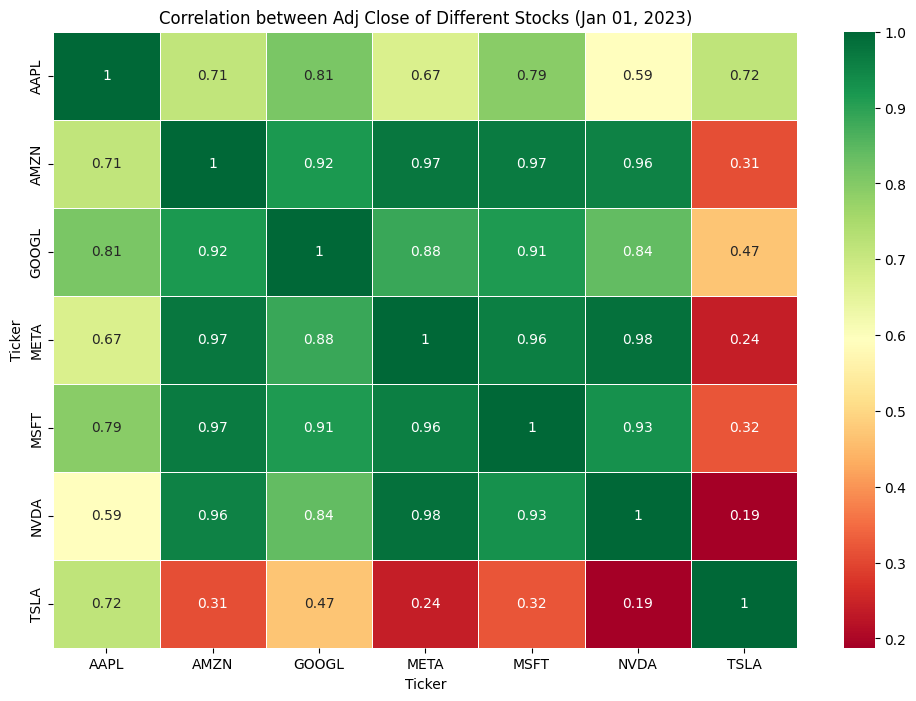

In [32]:
# Now let's filter the DataFrame to include data only from January 1, 2023.
filtered_df_3 = combined_df[combined_df['Date'] >= '2023-01-01']

# Pivot the filtered DataFrame to have "Ticker" as columns and "Adj Close" as values
pivot_df_3 = filtered_df_3.pivot(index='Date', columns='Ticker', values='Adj Close')

# Calculate the correlation matrix
corr_matrix_3 = pivot_df_3.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_3, annot=True, cmap="RdYlGn", linewidths=0.5)
plt.title('Correlation between Adj Close of Different Stocks (Jan 01, 2023)')
plt.xlabel('Ticker')
plt.ylabel('Ticker')
plt.show()

As expected we see an even stronger correlation between the stock price of the companies that have either developed a LLM or played a key role in development of AI. On the other hand, companies that have not shown any particular link to LLMs, such as AAPL and TSLA, are not strongly correlated with the other stocks anymore.

This is very interesting, even if not surprisingm and it shows that by picking one of these 5 strongly correlated stocks, we can estimate a prediction of the movement of the other 4 higly correlated stocks.

Another interesting aspect, is that TSLA has been working on AI and computer vision for years, been perhaps the leader in the R&D on the field. However, the correlation, together with the hype, seems to be only around the developers of Large Language Models and the cutting edge chip maker Nvdia (NVDA).

Now we can plot the stock price movement of the Magnificent Seven across the years, to get a clear visual representation. We use months and not days to avoid cluttering the plot.

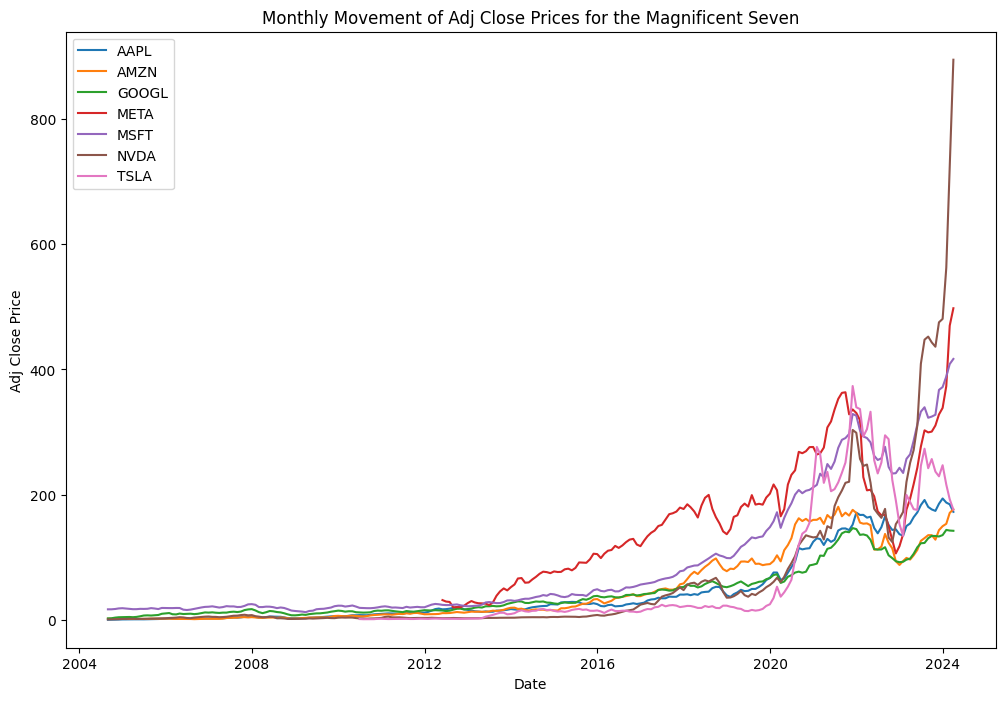

In [43]:
# Resample the DataFrame to monthly frequency for each ticker
monthly_df = combined_df.groupby(['Ticker']).resample('M').mean()

# Plot the movement of "Adj Close" for each company over time
plt.figure(figsize=(12, 8))
for ticker in monthly_df.index.get_level_values('Ticker').unique():
    company_data = monthly_df.loc[ticker]
    plt.plot(company_data.index, company_data['Adj Close'], label=ticker)

plt.title('Monthly Movement of Adj Close Prices for the Magnificent Seven')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()


Now that we have both the correlation matrix and the plot of the price movement of the different stocks, we can pick one between the five most correlated stocks, and start with our machine learning model.

As a model we want to compare simple Recurring Neural Networks (RNN), Long Short Term Memory (LSTM), and  Gated Recurring Units (GRUs), to see what model performs best in predicting the stock price.

## 3. Feature Engineering

In [16]:
combined_df = pd.read_pickle('magnificent_seven_historic_prices.pkl')

In [17]:
combined_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')

Looking at previous works, it doesn't look like "Volume" is a strong predictor of stock price.

In [18]:
df_num = combined_df.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['Volume'][:-1] # -1 means that the latest row is point_difference
top_features = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=False) #displays pearsons correlation coefficient greater than 0.5
print("There is {} correlated values with Volume:\n{}".format(len(top_features), top_features))

There is 5 correlated values with Volume:
Adj Close   -0.241572
High        -0.242397
Open        -0.243327
Close       -0.243392
Low         -0.244482
Name: Volume, dtype: float64


The correlation shows that there is not a strong correlation between Volume and the other variables, so we can drop the feature.

We will keep "Date" to define the time series, and remove "Ticker" once we pick a particular stock we want to analyze, so we don't have do feature engineering all over again for each Ticker.

Moreover, even if there is a strong multicollinearity between the different intraday prices, previous model have shown that adding all the intraday prices can improve the model. However, we do don't want to take this notion for granted, so we will start from the full dataset, and then test also a model with the "Adj Close" price only.

In [19]:
simplified_df = combined_df.drop('Volume', axis=1)
simplified_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Ticker'], dtype='object')

In [21]:
simplified_df.to_pickle('simplified_df.pkl')

In [22]:
# Create a directory to store the pickle files
os.makedirs("ticker_data", exist_ok=True)

In [52]:
# Create a StandardScaler instance
scaler = MinMaxScaler()

# List to store all DataFrames
all_dfs = []

# Iterate over each ticker
for ticker, df_group in simplified_df.groupby('Ticker'):
    # Drop the "Ticker" column from both standardized and non-standardized DataFrames
    df_group.drop(columns=['Ticker'], inplace=True)
    
    # Save the non-standardized DataFrame to a pickle file
    non_standardized_file_path = f"ticker_data/{ticker}_non_standardized.pkl"
    df_group.to_pickle(non_standardized_file_path)
    
    # Append the non-standardized DataFrame to the list
    all_dfs.append((f"{ticker}_non_standardized", df_group))
    
    # Copy the standardized DataFrame with only "Date" and "Adj Close" columns
    adj_close_df = df_group[['Date', 'Adj Close']].copy()
    
    # Save the DataFrame with only "Date" and "Adj Close" columns to a pickle file
    adj_close_file_path = f"ticker_data/{ticker}_adj_close.pkl"
    adj_close_df.to_pickle(adj_close_file_path)
    
    # Append the DataFrame with only "Date" and "Adj Close" columns to the list
    all_dfs.append((f"{ticker}_adj_close", adj_close_df))

# Convert the list of tuples to a dictionary for easy access
all_dfs_dict = dict(all_dfs)

Now we have create two dataframes for each ticker: one with the full set of value, except for "Volume", which was previously removed, and "Ticker". The other one has just the features "Adj Close" and "Date. We did that in the case we want to compare models with a different level of complexity later on.

Moreover, we have not run any standardization because we want to avoid data leakage when splitting the data into train and test sets.

Now we shall select one ticker to create our models. We can try by using MSFT, as the company plays a strong role in the AI rally and it's a major stakeholder of Open AI. Moreover, the company's stock price is very strongly correlated to the ones of GOOGL, AMZN, NVDA, and META.

In [5]:
MSFT_non_standardized = pd.read_pickle("ticker_data/MSFT_non_standardized.pkl")
MSFT_non_standardized.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close'], dtype='object')

In [54]:
MSFT_non_standardized.head()

,Date,Open,High,Low,Close,Adj Close
4936,2004-08-19,27.350000,27.450001,27.010000,27.120001,16.930798
4937,2004-08-20,27.129999,27.370001,27.040001,27.200001,16.980742
4938,2004-08-23,27.270000,27.330000,27.120001,27.240000,17.055878
4939,2004-08-24,27.400000,27.459999,27.090000,27.240000,17.055878
4940,2004-08-25,27.209999,27.670000,27.180000,27.549999,17.249975


In [6]:
MSFT_adj_close = pd.read_pickle("ticker_data/MSFT_adj_close.pkl")
MSFT_adj_close.columns

Index(['Date', 'Adj Close'], dtype='object')

In [7]:
MSFT_adj_close.head()

,Date,Adj Close
4936,2004-08-19,16.930798
4937,2004-08-20,16.980742
4938,2004-08-23,17.055878
4939,2004-08-24,17.055878
4940,2004-08-25,17.249975


## 4. Machine Learning Models

Let's split the data into training and test sets.

To make our models we will need standardized data, since stock prices can vary by huge amount, they may increased the computational power needed to train the model and slow the whole process down.

Since stock price data is only positive, we will use MinMaxScaler to maintain the original distribution of the data and avoid negative data, by producing values between 0 and 1 instead of between -1 and 1. Moreover, even if MinMaxScaler is more sensitive to outliers, we deem to have enough data to assume this is not going ot be a problem, and we prefer to have data between 0 and 1 over the robustness to outliers of RobustScaler.

In [8]:
#Make sure that the data is sorted by Date, since the order is important for timeseries predictive model
MSFT_non_standardized.sort_values(by='Date', inplace=True)

MSFT_non_standardized.head(5)

,Date,Open,High,Low,Close,Adj Close
4936,2004-08-19,27.350000,27.450001,27.010000,27.120001,16.930798
4937,2004-08-20,27.129999,27.370001,27.040001,27.200001,16.980742
4938,2004-08-23,27.270000,27.330000,27.120001,27.240000,17.055878
4939,2004-08-24,27.400000,27.459999,27.090000,27.240000,17.055878
4940,2004-08-25,27.209999,27.670000,27.180000,27.549999,17.249975


#### Split the Data in the complete dataset

In [9]:
# Split the data into training and test sets
train_data, test_data = train_test_split(MSFT_non_standardized, test_size=0.2, shuffle=False)

# Extract the target variable (Adj Close) from both training and test sets
y_train = train_data['Adj Close']
y_test = test_data['Adj Close']

# Set the Date column as index
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Define the feature sets (including the target variable since we are dealing with RNNs for timeseries data)
X_train = train_data.drop(columns=['Adj Close'])
X_test = test_data.drop(columns=['Adj Close'])

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Notice that we are not dropping the target feature in X_train and X_test with "X_train = train_data.drop(columns=['Adj Close'])
X_test = test_data.drop(columns=['Adj Close'])", like it's usually done in machine learning. This is because, Recurrent Neural Network use the previous inputs from the target variable to predict the output.

In [10]:
# Display the shapes of X_train, X_test, y_train, and y_test
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3948, 4)
X_test shape: (988, 4)
y_train shape: (3948,)
y_test shape: (988,)


In [102]:
X_train.to_pickle("X_train.pkl")
y_train.to_pickle("y_train.pkl")
X_test.to_pickle("X_test.pkl")
y_test.to_pickle("y_test.pkl")

In [2]:
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_test = pd.read_pickle('y_test.pkl')

We shall prepare the sequences of data we want to use to train the model.

In [11]:
# Prepare sequences for training
def prepare_sequences_X(data, sequence_length):
    X_sequences = []
    for i in range(len(data) - sequence_length):
        X_sequences.append(data[i:i+sequence_length])
    return np.array(X_sequences)

def prepare_sequences_y(target, sequence_length):
    y_targets = []
    for i in range(sequence_length, len(target)):  # Start from sequence_length to match X sequences
        y_targets.append(target.iloc[i])  # Use iloc to access by integer index
    return np.array(y_targets)

sequence_length = 30  # Number of past time steps to consider
X_train_seq = prepare_sequences_X(X_train_scaled, sequence_length)
y_train_seq = prepare_sequences_y(y_train, sequence_length)
X_test_seq = prepare_sequences_X(X_test_scaled, sequence_length)
y_test_seq = prepare_sequences_y(y_test, sequence_length)

Let's check if the shape of our dependent variable is correct, to prevent any data leakage from our independent features.

In [12]:
y_train_seq.shape

(3918,)

In [13]:
y_test_seq.shape

(958,)

The shape is correct.

### 4.1 Recurrent Neural Networks (RNN)

We can see that this model is doing very poorly.

Epoch 1/20


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1354.4503 - val_loss: 366.1965
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.4339 - val_loss: 410.5675
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.3876 - val_loss: 456.0104
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.4804 - val_loss: 256.3859
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.8174 - val_loss: 237.4996
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4988 - val_loss: 131.6214
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7349 - val_loss: 37.8920
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6448 - val_loss: 32.3450
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9577 - val_loss: 18.4452
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6074 - val_loss: 9.4819
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5337 - val_loss: 10.2497
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━

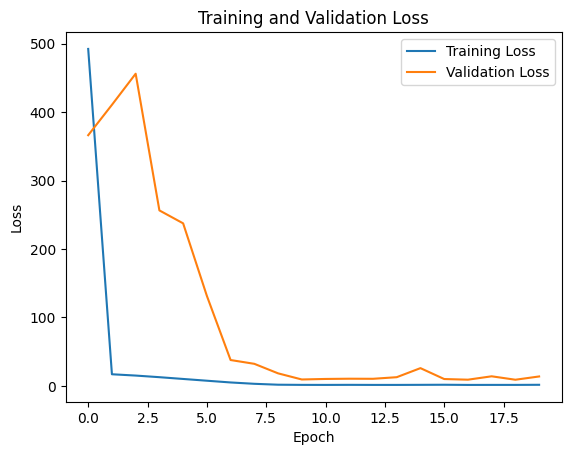

In [125]:
# Define the RNN model
model = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Reshape the training and test data for RNN input (add the time dimension)
X_train_rnn = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Train the model with validation data
history = model.fit(X_train_rnn, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_rnn, y_test))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


We can see that the training loss goes to a minimum after 9 epochs, and the validation loss goes to a minimum after 11 epochs; after that, it starts overfitting.

Let's plot the prediction and compared it to the actual data, to better visualize and understand the effectiveness of the model.

Check if y_pred is in the right format.

In [126]:
# Make predictions on the test data
y_pred = model.predict(X_test_rnn)
print(y_pred)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[169.45491]
 [167.2921 ]
 [168.90099]
 [172.98271]
 [170.12477]
 [170.36032]
 [175.43161]
 [176.6498 ]
 [177.68874]
 [178.38562]
 [178.95448]
 [179.12401]
 [175.17012]
 [172.45512]
 [175.87373]
 [179.21281]
 [178.89714]
 [178.9121 ]
 [178.95157]
 [177.37401]
 [178.4076 ]
 [174.02075]
 [175.84184]
 [176.6361 ]
 [176.3136 ]
 [177.73235]
 [178.82729]
 [178.05936]
 [178.74596]
 [180.65775]
 [182.86008]
 [188.3443 ]
 [185.43584]
 [183.18152]
 [181.1113 ]
 [187.44203]
 [188.90514]
 [189.00792]
 [191.23766]
 [191.87318]
 [196.39992]
 [194.36427]
 [192.38362]
 [192.02504]
 [190.38284]
 [194.74045]
 [197.98322]
 [200.24571]
 [203.50801]
 [204.9648 ]
 [205.02757]
 [208.70891]
 [206.9543 ]
 [205.96764]
 [200.19994]
 [202.73398]
 [198.38173]
 [197.54478]
 [201.80452]
 [205.6122 ]
 [204.23895]
 [200.62326]
 [194.52934]
 [196.32704]
 [197.17397]
 [197.15855]
 [196.08032]
 [197.2182 ]
 [207.9073 ]
 [207.1306 ]
 [207.6755 ]
 [207.89458]
 [207.718  ]
 [203.84529]

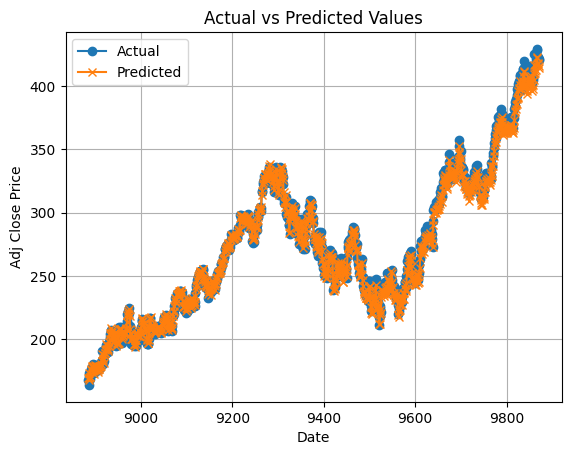

In [127]:
# Plot the actual and predicted values
plt.plot(y_test.index, y_test.values, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In the model above, the input shape specified in the SimpleRNN layer is (X_train.shape[1], 1), indicating that each input sample is a sequence of features (time steps), and each feature consists of a single value. This model is suitable when your input data has only one feature (e.g., univariate time series data). However, we can suspect that the model is overfitting the data.

Let's edit the model a little bit by allowing multiple features.

In the model below, the input shape specified in the SimpleRNN layer is (X_train_seq.shape[1], X_train_seq.shape[2]), where X_train_seq.shape[1] represents the number of time steps in each sequence, and X_train_seq.shape[2] represents the number of features in each time step. This model is suitable when the input data consists of sequences of multiple features (e.g., multivariate time series data).

Epoch 1/20


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1691.7916 - val_loss: 359.7346
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.2127 - val_loss: 428.0274
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.0379 - val_loss: 1064.8203
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.8993 - val_loss: 715.7131
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37.8992 - val_loss: 970.3339
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.7453 - val_loss: 433.5339
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.5854 - val_loss: 343.8181
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.6159 - val_loss: 1372.5887
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.2735 - val_loss: 464.7423
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8901 - val_loss: 949.8531
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.2575 - val_loss: 570.5753
Epoch 12/20
123/123 ━━━━━━

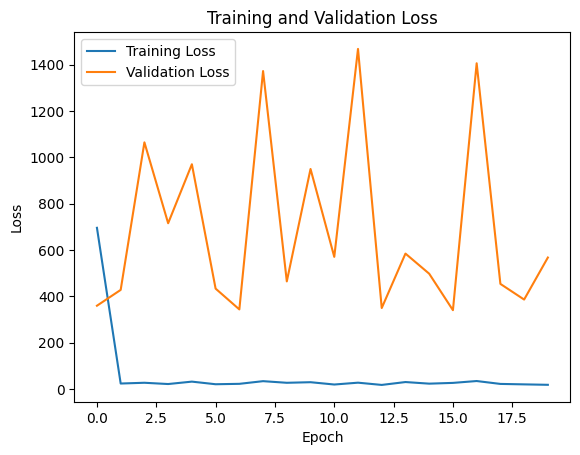

In [128]:
# Define the RNN model
model = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


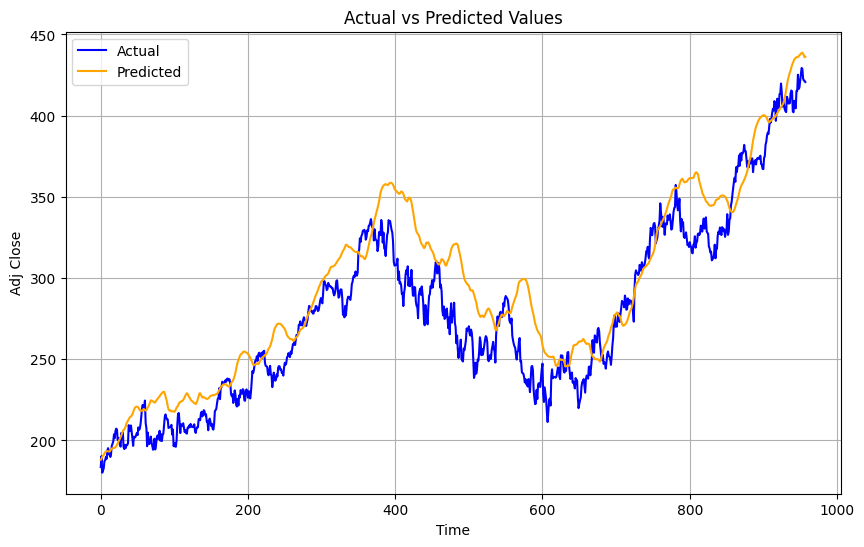

In [129]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

Let's add one Dense layer to the model.

Epoch 1/20


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1509.7687 - val_loss: 433.6245
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2458 - val_loss: 2942.0298
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.6360 - val_loss: 333.9067
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.1633 - val_loss: 442.3374
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.0115 - val_loss: 354.9125
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.6959 - val_loss: 318.2426
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.9873 - val_loss: 701.6490
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.5866 - val_loss: 2120.9724
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42.8578 - val_loss: 1726.4883
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.2638 - val_loss: 373.9825
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.6311 - val_loss: 309.8797
Epoch 12/20
123/123 ━━━━━

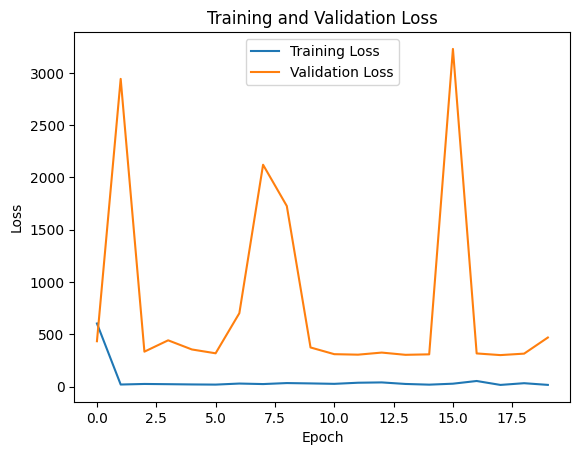

In [132]:
# Define the RNN model
model = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


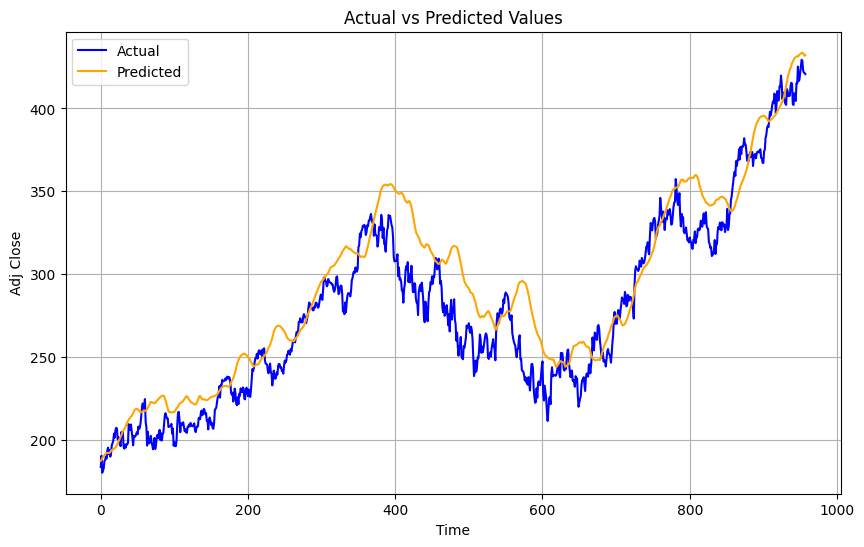

In [133]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

This is not bad in predicting macro price movements in medium-long periods of time. However, the model is still underfitting the data and it's unfit in predicting short-term movements. Let's add some Deep layers and increase the number of Epochs.

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1319.8350 - val_loss: 557.2775
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.4851 - val_loss: 468.0033
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.8631 - val_loss: 315.4937
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.5172 - val_loss: 1645.8632
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6327 - val_loss: 355.0238
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.6892 - val_loss: 439.3819
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.6185 - val_loss: 655.3046
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1116 - val_loss: 465.1786
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.5230 - val_loss: 1200.6821
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.7002 - val_loss: 1136.0027
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.6163 - val_loss: 728.2003
Epo

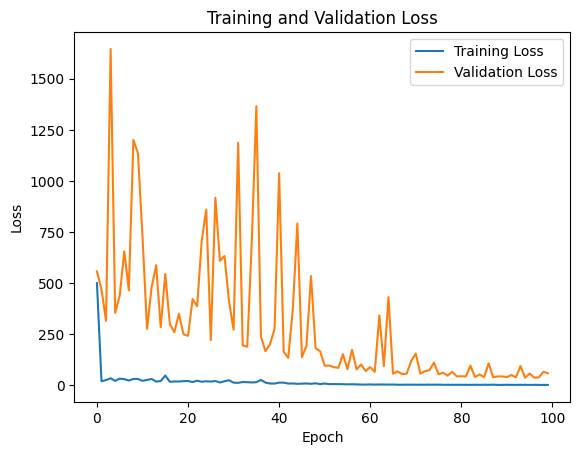

In [146]:
# Define the RNN model
model = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We can see that the Validation Loss gets very close to the Training Loss (and to 0) and stabilizes around 80 epochs.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


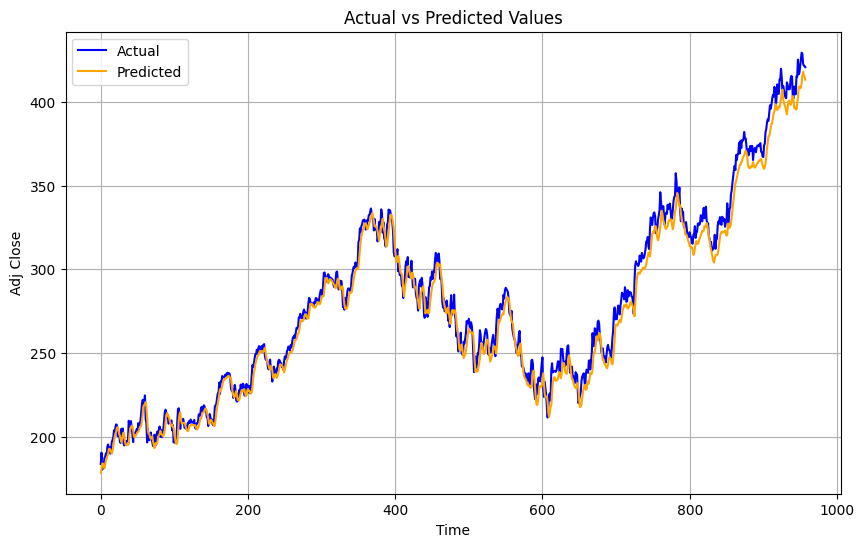

In [147]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

The model is performing very well, perhaps too well. Is it overfitting? Let's add Dropout to the dense layers to randomly drop neurons and reduce the chances of overfitting.

Epoch 1/100


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2968.2671 - val_loss: 77824.1719
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2274.2258 - val_loss: 48102.8203
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1797.6821 - val_loss: 18759.6445
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 923.6650 - val_loss: 20990.4492
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 905.0124 - val_loss: 24957.2793
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 701.4265 - val_loss: 13897.4629
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 708.9375 - val_loss: 6961.3501
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 555.7017 - val_loss: 4090.5496
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 535.1310 - val_loss: 3568.8884
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 465.4976 - val_loss: 14675.9580
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 473.9211 - val_loss

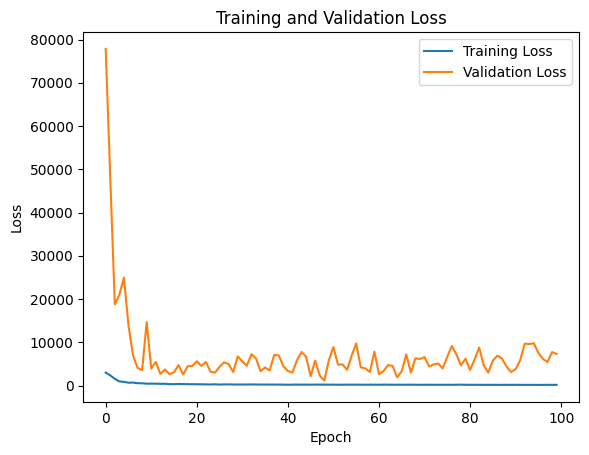

In [14]:
# Define the RNN model with dropout
model = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dropout(0.5),  # Dropout layer with dropout rate of 0.5
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


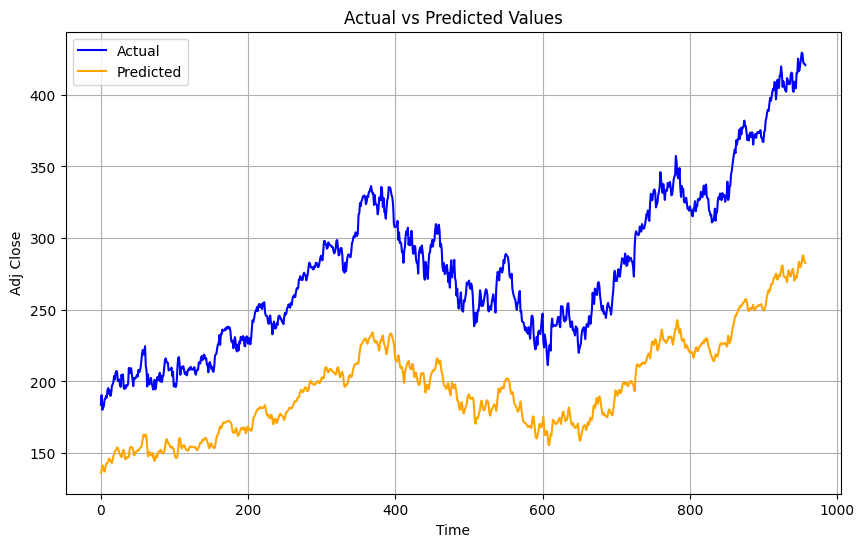

In [15]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

It seems that the model performs more poorly than before, and we cannot be totally sure that the random drop of neurons is preventing overfitting, since the Predicted line strongly matches the Actual line, but it;s translated about 50 points below.

Let's try to reduce Dropout to 0.25 and see what happens.

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1851.6747 - val_loss: 7077.6528
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 329.7236 - val_loss: 10694.8389
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 345.6634 - val_loss: 4884.1172
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 277.2459 - val_loss: 13820.2021
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 270.9626 - val_loss: 13891.6943
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181.7767 - val_loss: 11558.2881
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 206.6281 - val_loss: 6166.9321
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 240.5429 - val_loss: 16023.6875
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 232.8048 - val_loss: 10361.6904
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181.6669 - val_loss: 22810.4570
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168.8108 

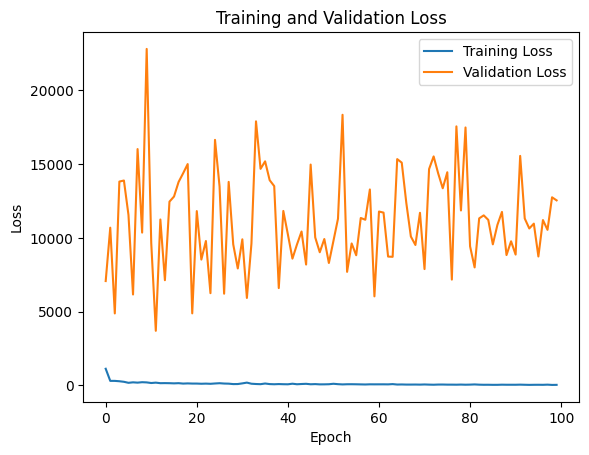

In [16]:
# Define the RNN model with dropout
model = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.25),  # Dropout layer with dropout rate of 0.5
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dropout(0.25),  # Dropout layer with dropout rate of 0.5
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dropout(0.25),  # Dropout layer with dropout rate of 0.5
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


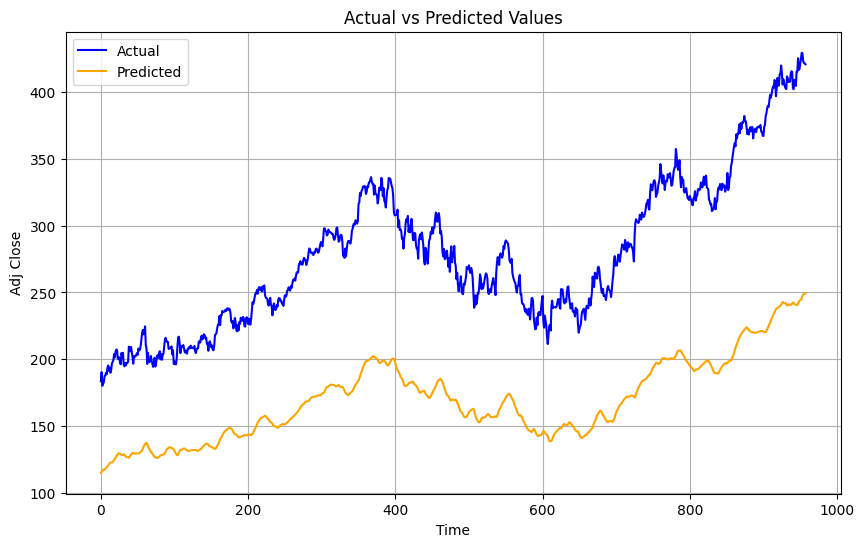

In [17]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

The model is actually dooing worse with Dropout = 0.25.

By plotting the data we can see that our prediction is very close to the actual values. Perhaps, with more epochs, we could get even closer, but we don't want to risk overfitting the model. Indeed, the model may be already overfitting, since it looks too good to be true. So, let's try to build a deep learning model by using only "Adj Close" as feature, so the model can't guess from the variations in the daily prices and needs to predict the price movements from the previous prices.

### 4.2 Long Short Term Memory (LSTM)

Now we are going to try a Long Short Term Memory model. LSTMs can learn more complex and long-range patterns, but the higher complexity makes them slower to train. LSTMs can selectively remember or forget the relevant information, while simple RNNs have limited memory capacity.


Epoch 1/20


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6879.4478 - val_loss: 1325767.3750
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 679.8711 - val_loss: 7425.2417
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.8914 - val_loss: 5173.6431
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 15.4051 - val_loss: 4963.9561
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 15.4645 - val_loss: 5073.0215
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 13.8701 - val_loss: 3026.1770
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 18.8804 - val_loss: 2639.1995
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.5495 - val_loss: 1289.4915
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 16.4077 - val_loss: 1818.1781
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 12.3754 - val_loss: 1550.3331
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14.5479 - val_loss: 1450.3263
Epoch 12/20
1

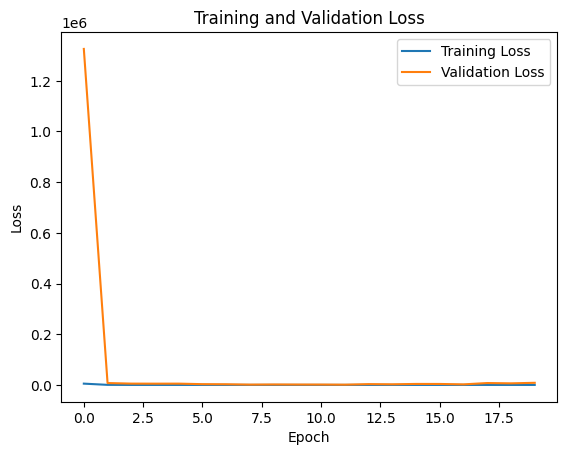

In [134]:
# Define the RNN model
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


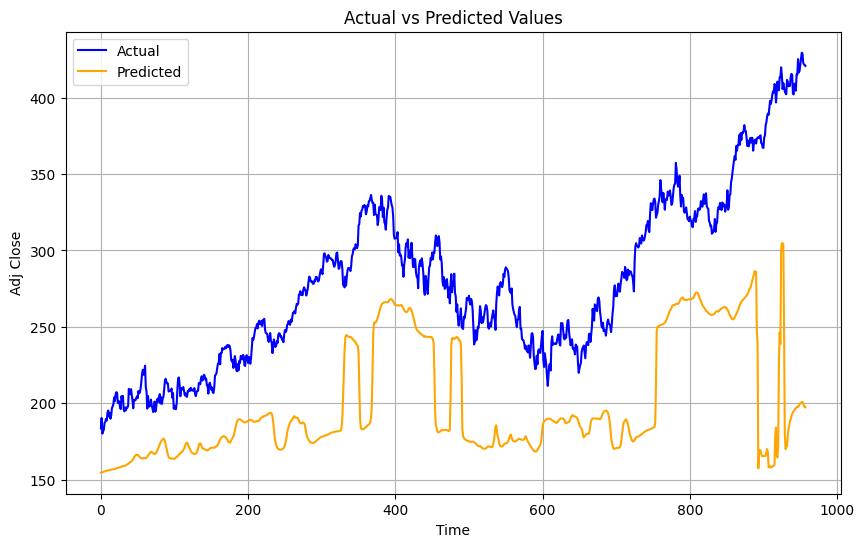

In [135]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


We can see that the model is doing terribly here, and it underfits the data. Let's add a Dense layer and see if the model improves.

Epoch 1/20


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2377.1460 - val_loss: 5728.5967
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.6894 - val_loss: 6798.8071
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.4945 - val_loss: 2140.2798
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.7008 - val_loss: 350.6281
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.1031 - val_loss: 619.6851
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.1087 - val_loss: 558.7299
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.4297 - val_loss: 1445.3684
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.7227 - val_loss: 482.6668
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.6110 - val_loss: 4202.0659
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 17.9747 - val_loss: 3200.3740
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.3256 - val_loss: 4812.7988
Epoch 12/20
123/123 ━

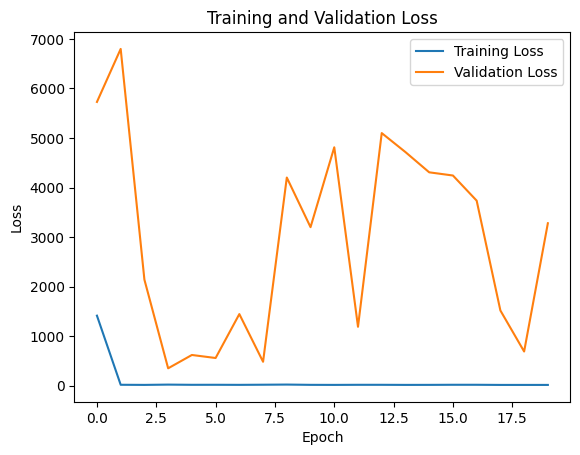

In [141]:
# Define the RNN model with an additional Dense layer
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


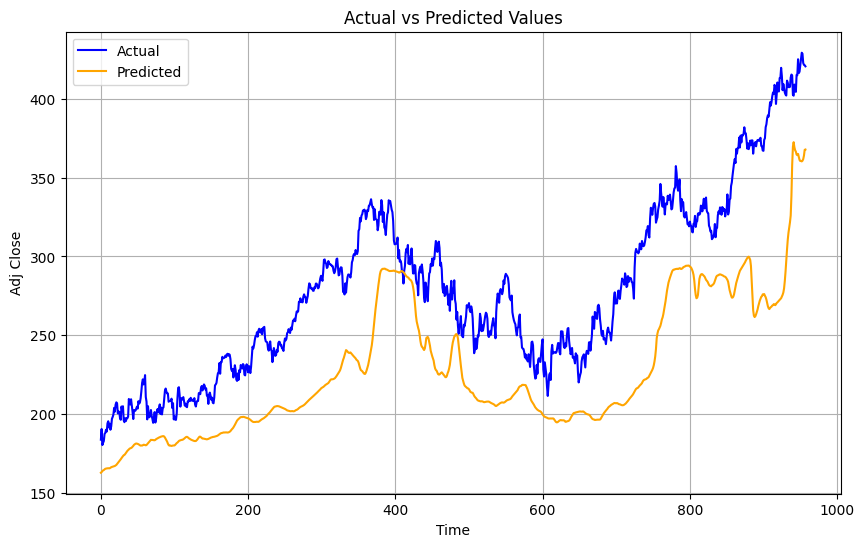

In [142]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

The model improves in getting the macto trends, but it's still underfitting the data. Let's add more Dense layers and Epochs.

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2679.0750 - val_loss: 7254.6621
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 29.9962 - val_loss: 5266.4814
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.7632 - val_loss: 487.6580
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.9988 - val_loss: 397.6570
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.9627 - val_loss: 737.8293
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.0354 - val_loss: 748.2060
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.9435 - val_loss: 2562.3230
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.5616 - val_loss: 1845.6066
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.7917 - val_loss: 1423.1428
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.4549 - val_loss: 1892.0665
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.9376 - val_loss: 5013.4038

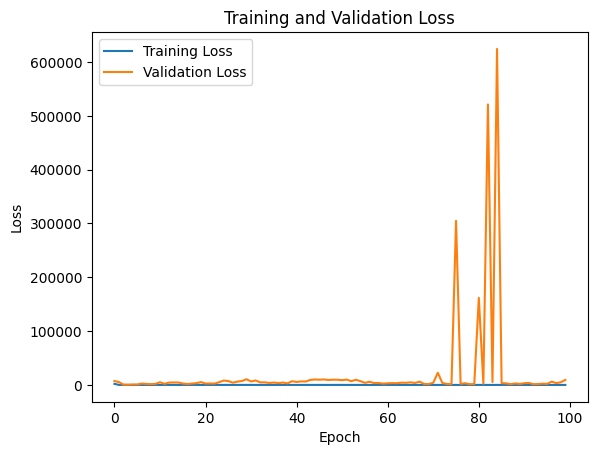

In [156]:
# Define the RNN model with an additional Dense layer
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


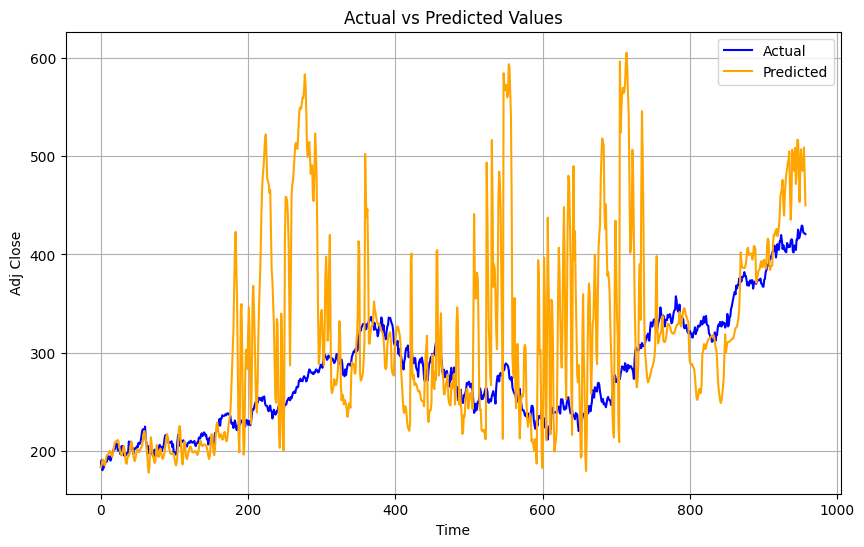

In [157]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

It loosk like the model with LSTM is not able to make predictions on the data.

Epoch 1/300


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2684.7451 - val_loss: 4082.7078
Epoch 2/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 198.1118 - val_loss: 16448.6777
Epoch 3/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.9441 - val_loss: 4725.6685
Epoch 4/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 18.3497 - val_loss: 2467.7812
Epoch 5/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.8231 - val_loss: 3207.2766
Epoch 6/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.9131 - val_loss: 1206.7203
Epoch 7/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 25.1935 - val_loss: 1737.6245
Epoch 8/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.1591 - val_loss: 1296.3289
Epoch 9/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 20.8359 - val_loss: 1364.3951
Epoch 10/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.3295 - val_loss: 1293.3488
Epoch 11/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 15.6146 - val_loss: 1280.6669
Epoch

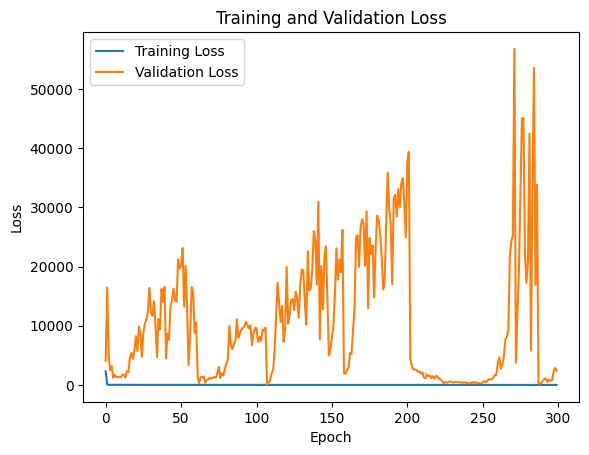

In [154]:
# Define the RNN model with an additional Dense layer
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=300, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

We can see that the loss reaches a minimum between the 220 and 250 epochs, perhaps overfitting the data, and then it gets out of control afterwards.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


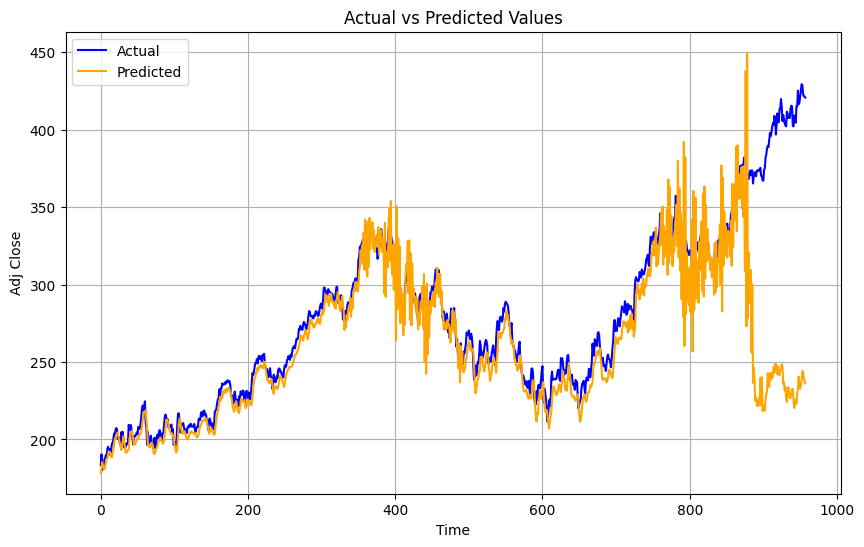

In [155]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/300


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2679.2876 - val_loss: 16180.4570
Epoch 2/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 969.3636 - val_loss: 29459.1465
Epoch 3/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 647.3647 - val_loss: 15451.2900
Epoch 4/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 685.8375 - val_loss: 18648.4512
Epoch 5/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 574.8257 - val_loss: 22165.2461
Epoch 6/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 458.1178 - val_loss: 19609.5000
Epoch 7/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 428.1493 - val_loss: 22374.1074
Epoch 8/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 447.0436 - val_loss: 18589.8848
Epoch 9/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 440.6188 - val_loss: 24080.0527
Epoch 10/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 352.7970 - val_loss: 24583.4902
Epoch 11/300
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 382.9029 - val_los

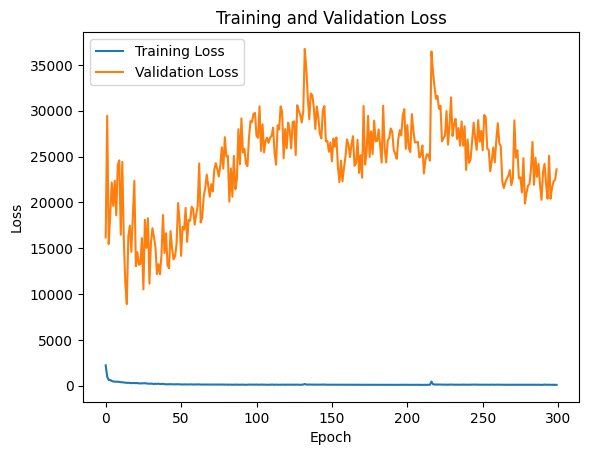

In [18]:
# Define the RNN model with an additional Dense layer
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.5),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dropout(0.5),
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dropout(0.5),
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=300, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


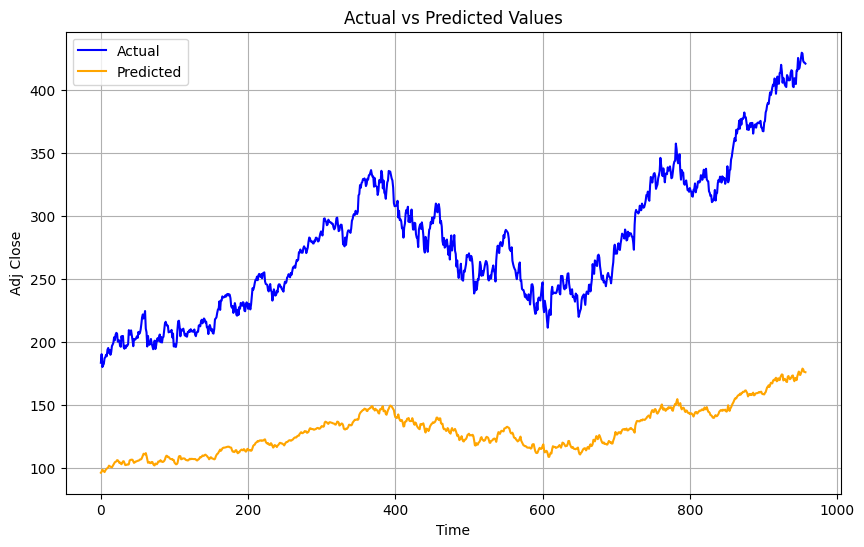

In [19]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In LSTM seems to greatly improve the model, even if the model is still not good enough, and looking at the behavior of the loss, it doesn't seem that adding more epochs will do any better. Perhaps, the model would beneift from more deep layers, and this could be a future improvement to the model.

Adding too many epochs makes the model go out of control. It looks that, surprisingly, Simple RNNs have done a much better job in predicting the stock price so far. However, before comfirming our winner, we want to try with GRUs too.

### 4.3 Gated Recurring Units (GRUs)

Epoch 1/50


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2783.3660 - val_loss: 7054.6948
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 119.7810 - val_loss: 3177.8850
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.6316 - val_loss: 1141.4722
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.6132 - val_loss: 904.0356
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.6201 - val_loss: 489.9511
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.5619 - val_loss: 1257.7166
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.7081 - val_loss: 1279.5623
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.2994 - val_loss: 1246.4421
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.9945 - val_loss: 805.2377
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.0567 - val_loss: 1106.9176
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 13.0085 - val_loss: 1137.8948
Epoch 12/50
123/123

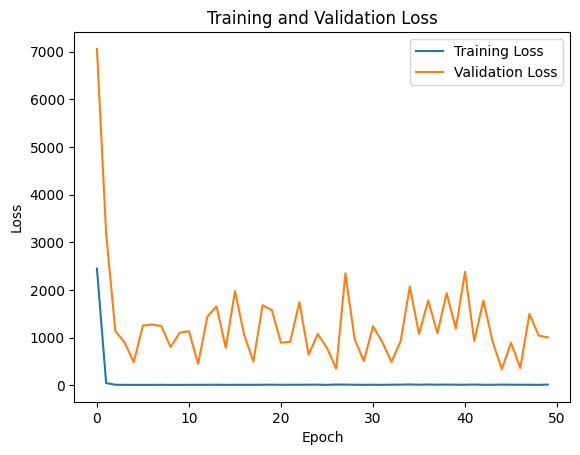

In [150]:
# Define the RNN model with GRU layer
model = Sequential([
    GRU(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


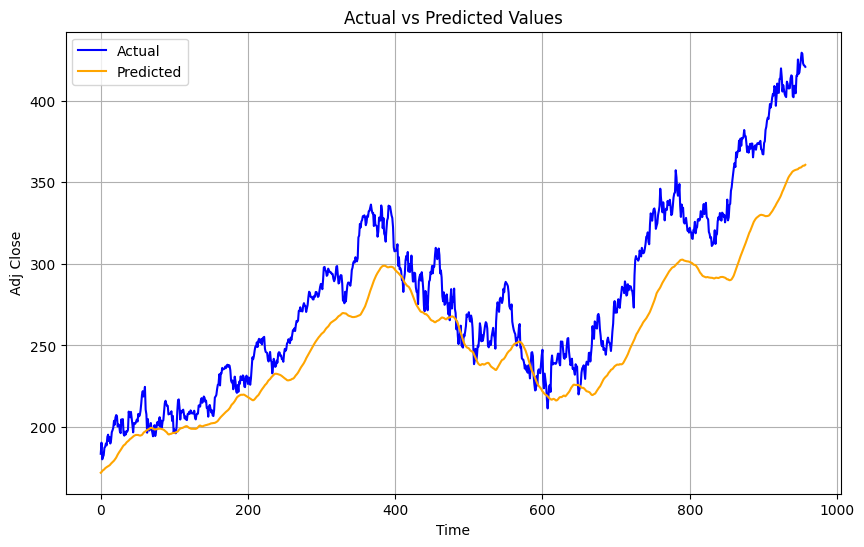

In [151]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

We can see that the model undefits the data. Let's add some dense layers and epochs.

Epoch 1/100


123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2502.3572 - val_loss: 301.2271
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.9946 - val_loss: 323.5593
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.6365 - val_loss: 257.4410
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.2980 - val_loss: 299.0460
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.3569 - val_loss: 364.6378
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.1079 - val_loss: 1486.8245
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.5592 - val_loss: 1317.0559
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.8609 - val_loss: 1677.7211
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.1525 - val_loss: 1629.5903
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.9348 - val_loss: 338.6340
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 16.2718 - val_loss: 1874.7006
Epoch 12/100


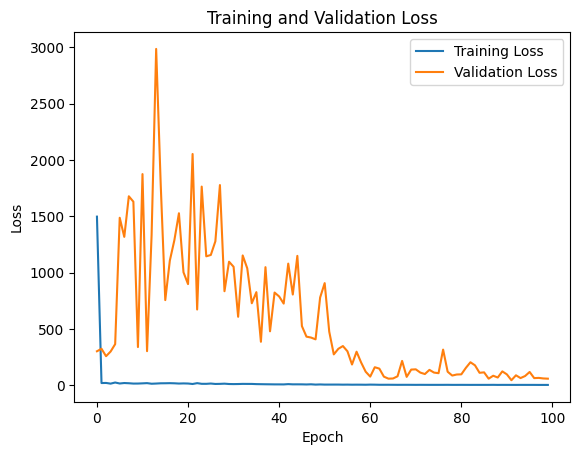

In [152]:
# Define the RNN model with an additional Dense layer
model = Sequential([
    GRU(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


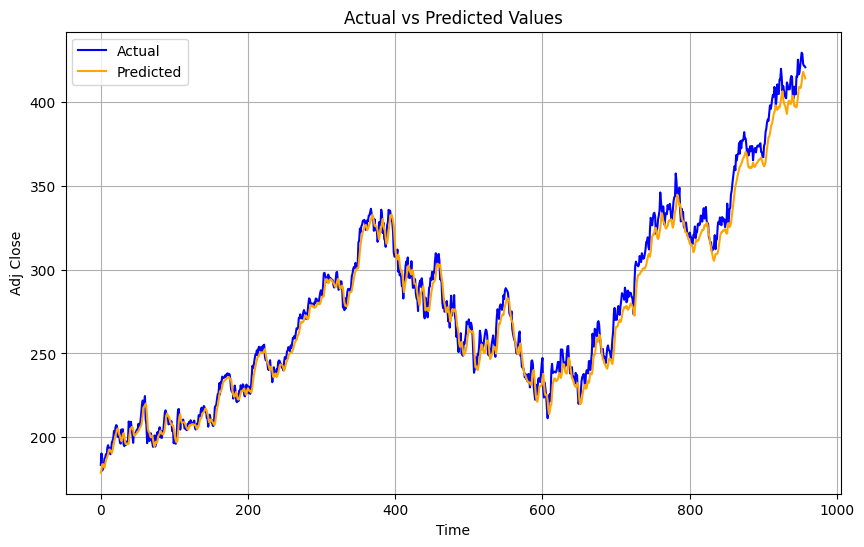

In [153]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

It looks like GRUs is our best model so far, and the loss stabilizes between the 90 and 100 epochs.

Epoch 1/100


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2613.1780 - val_loss: 30454.5410
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 835.3407 - val_loss: 23743.3789
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 652.1926 - val_loss: 23654.1914
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 577.9794 - val_loss: 19816.3398
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 508.0001 - val_loss: 16455.4336
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 494.8514 - val_loss: 23530.7676
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 442.0117 - val_loss: 19338.6543
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 374.0619 - val_loss: 16000.6143
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 398.5226 - val_loss: 16554.6387
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 345.0930 - val_loss: 20475.4062
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 397.5348 - val_los

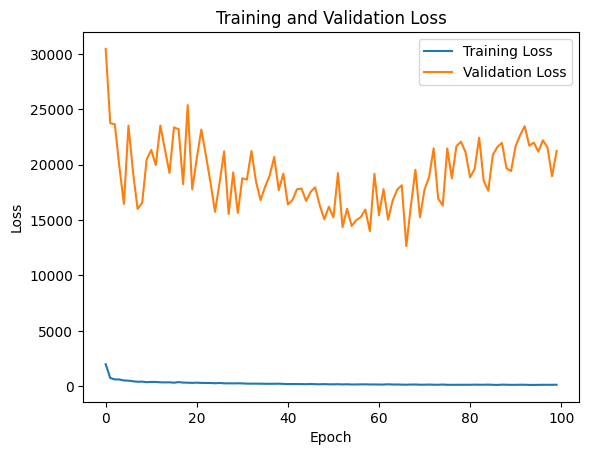

In [20]:
# Define the RNN model with an additional Dense layer
model = Sequential([
    GRU(units=64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.5),
    Dense(units=32, activation='relu'),  # Additional Dense layer
    Dropout(0.5),
    Dense(units=16, activation='relu'),  # Additional Dense layer
    Dropout(0.5),
    Dense(units=8, activation='relu'),  # Additional Dense layer
    Dense(units=1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_seq, y_test_seq))

# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


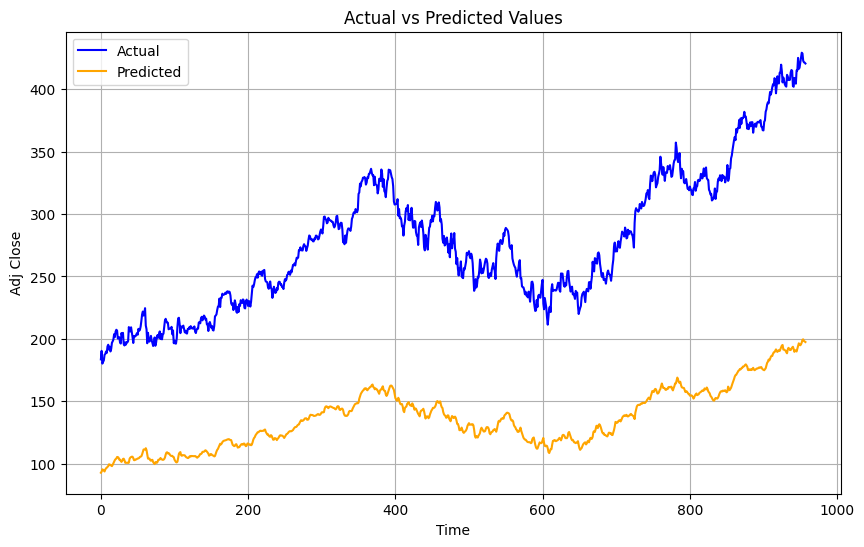

In [21]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

Like with the other models, it looks like adding Dropout traslates the values below (in this case of roughly 100 points), rather than preventing overfiting per se. So we are going to choose our deeplearning GRUs model without any Dropout as our best model.

## 5. Results

Surprisingly LSTM was the worse performing model, and perhaps it would have benefitted from adding more layers. Moreover, it looks like Dropout did not add much protection against overfiting, and instead, it simply trslated the model down by 50-100 points.

## 6. Conclusions

The two models with the best performance are the Simple RNNs and the GRUs with deep dense layers. Between the two, we shall select the GRUs model, as the distance between Actual and Predicted values looks smaller.

## 7. Next Steps

In the future, we can try to create the same models but we just a simple dataset containing only the dependent variable "Adj Close" as a feature. By doing so, we can try to predict future stock prices by looking only at previous movements, without the influence of intraday movements, which can lead to overfitting through Multicollinearity.

Indeed, Neural Networks and Machine Learning in general, when applied to stock price prediction is often very prone to overfitting. By using intraday price movevents, such as Open, Close, High, Low, other than our target variable Adj Close, we are increasing the chances of overfitting. Moreover, this model, as models that try to predict stock price, work on momentum, and a change of momentum would make the model much weaker. Especially if the change is drastic, such as it may happen with long tail drastic events such as Covid-19 and the AI rally.

These models are just an exercises, and before being applied to real world problems, they will need much more fine tuning and parameters selection.